<a href="https://colab.research.google.com/github/nguyenhuy-vn/Finger-identification-based-on-capacitives-touch-screen/blob/main/ShuffleNet_with_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras import datasets, models, layers

### Load data

In [3]:
X_train = np.load('/content/drive/MyDrive/data for 2/X_train.npy')
X_test = np.load('/content/drive/MyDrive/data for 2/X_test.npy')
X_val = np.load('/content/drive/MyDrive/data for 2/X_val.npy')
Y_train = np.load('/content/drive/MyDrive/data for 2/Y_train.npy')
Y_test = np.load('/content/drive/MyDrive/data for 2/Y_test.npy')
Y_val = np.load('/content/drive/MyDrive/data for 2/Y_val.npy')
label = np.load('/content/drive/MyDrive/data for 2/label.npy')

### Check if have any missing data

In [4]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((61122, 32, 32),
 (19168, 32, 32),
 (15281, 32, 32),
 (61122, 2),
 (19168, 2),
 (15281, 2))

In [5]:
X_train[0]

array([[0.02745098, 0.02745098, 0.02745098, ..., 0.04313726, 0.04313726,
        0.04313726],
       [0.02745098, 0.02745098, 0.02745098, ..., 0.04313726, 0.04313726,
        0.04313726],
       [0.02745098, 0.02745098, 0.02745098, ..., 0.04313726, 0.04313726,
        0.04313726],
       ...,
       [0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.05882353, 0.05882353, 0.05882353, ..., 0.07058824, 0.07058824,
        0.07058824]], dtype=float32)

In [6]:
X_val[0]

array([[0.00784314, 0.00784314, 0.00784314, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.02745098, 0.02745098,
        0.02745098],
       ...,
       [0.01568628, 0.01568628, 0.01568628, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.07058824, 0.07058824,
        0.07058824]], dtype=float32)

In [7]:
Y_train[0]

array([0., 1.])

### Model and Train

In [8]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0],32,32,1)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend

def channel_shuffle(x, groups):
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]
    group_channels = channels // groups

    x = tf.reshape(x, [-1, height, width, groups, group_channels])
    x = tf.transpose(x, [0, 1, 2, 4, 3])
    x = tf.reshape(x, [-1, height, width, channels])
    return x

def grouped_convolution(x, out_channels, groups):
    in_channels = x.shape[-1]
    group_list = []

    for i in range(groups):
        group_list.append(layers.Conv2D(out_channels // groups, kernel_size=1, strides=1, padding='same',
                                        use_bias=False)(x[:, :, :, i * in_channels // groups:(i + 1) * in_channels // groups]))
    return layers.Concatenate()(group_list)

def shuffle_unit(inputs, in_channels, out_channels, strides, groups):
    x = grouped_convolution(inputs, in_channels, groups)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = grouped_convolution(x, out_channels if strides == 1 else out_channels - in_channels, groups)
    x = layers.BatchNormalization()(x)

    if strides == 2:
        shortcut = layers.AveragePooling2D(pool_size=3, strides=2, padding='same')(inputs)
        x = layers.Concatenate()([x, shortcut])
    elif strides == 1:
        x = layers.Add()([inputs, x])

    x = layers.ReLU()(x)
    x = channel_shuffle(x, groups)
    return x

def ShuffleNet(input_shape=(224, 224, 3), num_classes=1000, scale_factor=1.0, groups=3):
    in_channels = 24
    out_channels = {1: [144, 288, 576], 2: [200, 400, 800], 3: [240, 480, 960], 4: [272, 544, 1088], 8: [384, 768, 1536]}[groups]
    out_channels = [int(c * scale_factor) for c in out_channels]

    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(in_channels, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    for out_channel in out_channels:
        repeat = 4 if out_channel != out_channels[0] else 3
        for i in range(repeat):
            strides = 2 if i == 0 else 1
            x = shuffle_unit(x, in_channels, out_channel, strides, groups)
            in_channels = out_channel

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
model = ShuffleNet(input_shape = (32,32,1), num_classes = 2)
from keras.optimizers import SGD
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy", f1_m, precision_m, recall_m])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 24)           216       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 24)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 16, 16, 24)           0         ['batch_normalization[0][0

In [13]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuraccy")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs= 50, validation_data=(X_val, Y_val),callbacks=[es])

Epoch 1/50
239/238 [==============================] - ETA: 0s - loss: 0.7802 - accuracy: 0.6058 - f1_m: 0.6056 - precision_m: 0.6056 - recall_m: 0.6056

238/238 [==============================] - 57s 119ms/step - loss: 0.7802 - accuracy: 0.6058 - f1_m: 0.6056 - precision_m: 0.6056 - recall_m: 0.6056 - val_loss: 0.6976 - val_accuracy: 0.4790 - val_f1_m: 0.4790 - val_precision_m: 0.4790 - val_recall_m: 0.4790
Epoch 2/50
239/238 [==============================] - ETA: 0s - loss: 0.5562 - accuracy: 0.7148 - f1_m: 0.7148 - precision_m: 0.7148 - recall_m: 0.7148

238/238 [==============================] - 26s 107ms/step - loss: 0.5562 - accuracy: 0.7148 - f1_m: 0.7148 - precision_m: 0.7148 - recall_m: 0.7148 - val_loss: 0.7231 - val_accuracy: 0.4790 - val_f1_m: 0.4790 - val_precision_m: 0.4790 - val_recall_m: 0.4790
Epoch 3/50
239/238 [==============================] - ETA: 0s - loss: 0.4452 - accuracy: 0.7867 - f1_m: 0.7868 - precision_m: 0.7868 - recall_m: 0.7868

238/238 [==============================] - 26s 109ms/step - loss: 0.4452 - accuracy: 0.7867 - f1_m: 0.7868 - precision_m: 0.7868 - recall_m: 0.7868 - val_loss: 0.4989 - val_accuracy: 0.7421 - val_f1_m: 0.7420 - val_precision_m: 0.7420 - val_recall_m: 0.7420
Epoch 4/50
239/238 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8217 - f1_m: 0.8217 - precision_m: 0.8217 - recall_m: 0.8217

238/238 [==============================] - 42s 177ms/step - loss: 0.3953 - accuracy: 0.8217 - f1_m: 0.8217 - precision_m: 0.8217 - recall_m: 0.8217 - val_loss: 0.5109 - val_accuracy: 0.7749 - val_f1_m: 0.7749 - val_precision_m: 0.7749 - val_recall_m: 0.7749
Epoch 5/50
239/238 [==============================] - ETA: 0s - loss: 0.3477 - accuracy: 0.8437 - f1_m: 0.8437 - precision_m: 0.8437 - recall_m: 0.8437

238/238 [==============================] - 25s 106ms/step - loss: 0.3477 - accuracy: 0.8437 - f1_m: 0.8437 - precision_m: 0.8437 - recall_m: 0.8437 - val_loss: 0.3912 - val_accuracy: 0.8321 - val_f1_m: 0.8319 - val_precision_m: 0.8319 - val_recall_m: 0.8319
Epoch 6/50
239/238 [==============================] - ETA: 0s - loss: 0.3186 - accuracy: 0.8580 - f1_m: 0.8580 - precision_m: 0.8580 - recall_m: 0.8580

238/238 [==============================] - 25s 105ms/step - loss: 0.3186 - accuracy: 0.8580 - f1_m: 0.8580 - precision_m: 0.8580 - recall_m: 0.8580 - val_loss: 0.3360 - val_accuracy: 0.8491 - val_f1_m: 0.8491 - val_precision_m: 0.8491 - val_recall_m: 0.8491
Epoch 7/50
239/238 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.8675 - f1_m: 0.8675 - precision_m: 0.8675 - recall_m: 0.8675

238/238 [==============================] - 27s 112ms/step - loss: 0.3021 - accuracy: 0.8675 - f1_m: 0.8675 - precision_m: 0.8675 - recall_m: 0.8675 - val_loss: 0.4201 - val_accuracy: 0.8338 - val_f1_m: 0.8338 - val_precision_m: 0.8338 - val_recall_m: 0.8338
Epoch 8/50
239/238 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.8760 - f1_m: 0.8760 - precision_m: 0.8760 - recall_m: 0.8760

238/238 [==============================] - 27s 115ms/step - loss: 0.2821 - accuracy: 0.8760 - f1_m: 0.8760 - precision_m: 0.8760 - recall_m: 0.8760 - val_loss: 0.2703 - val_accuracy: 0.8840 - val_f1_m: 0.8838 - val_precision_m: 0.8838 - val_recall_m: 0.8838
Epoch 9/50
239/238 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.8813 - f1_m: 0.8813 - precision_m: 0.8813 - recall_m: 0.8813

238/238 [==============================] - 24s 102ms/step - loss: 0.2725 - accuracy: 0.8813 - f1_m: 0.8813 - precision_m: 0.8813 - recall_m: 0.8813 - val_loss: 0.3517 - val_accuracy: 0.8545 - val_f1_m: 0.8541 - val_precision_m: 0.8541 - val_recall_m: 0.8541
Epoch 10/50
239/238 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.8841 - f1_m: 0.8841 - precision_m: 0.8841 - recall_m: 0.8841

238/238 [==============================] - 25s 104ms/step - loss: 0.2658 - accuracy: 0.8841 - f1_m: 0.8841 - precision_m: 0.8841 - recall_m: 0.8841 - val_loss: 0.2943 - val_accuracy: 0.8742 - val_f1_m: 0.8738 - val_precision_m: 0.8738 - val_recall_m: 0.8738
Epoch 11/50
239/238 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.8883 - f1_m: 0.8883 - precision_m: 0.8883 - recall_m: 0.8883

238/238 [==============================] - 25s 105ms/step - loss: 0.2559 - accuracy: 0.8883 - f1_m: 0.8883 - precision_m: 0.8883 - recall_m: 0.8883 - val_loss: 0.2875 - val_accuracy: 0.8738 - val_f1_m: 0.8733 - val_precision_m: 0.8733 - val_recall_m: 0.8733
Epoch 12/50
239/238 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.8945 - f1_m: 0.8945 - precision_m: 0.8945 - recall_m: 0.8945

238/238 [==============================] - 26s 107ms/step - loss: 0.2452 - accuracy: 0.8945 - f1_m: 0.8945 - precision_m: 0.8945 - recall_m: 0.8945 - val_loss: 0.3730 - val_accuracy: 0.8476 - val_f1_m: 0.8475 - val_precision_m: 0.8475 - val_recall_m: 0.8475
Epoch 13/50
239/238 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.8952 - f1_m: 0.8952 - precision_m: 0.8952 - recall_m: 0.8952

238/238 [==============================] - 25s 106ms/step - loss: 0.2428 - accuracy: 0.8952 - f1_m: 0.8952 - precision_m: 0.8952 - recall_m: 0.8952 - val_loss: 0.2809 - val_accuracy: 0.8865 - val_f1_m: 0.8862 - val_precision_m: 0.8862 - val_recall_m: 0.8862
Epoch 14/50
239/238 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9014 - f1_m: 0.9014 - precision_m: 0.9014 - recall_m: 0.9014

238/238 [==============================] - 25s 106ms/step - loss: 0.2316 - accuracy: 0.9014 - f1_m: 0.9014 - precision_m: 0.9014 - recall_m: 0.9014 - val_loss: 0.2423 - val_accuracy: 0.8978 - val_f1_m: 0.8976 - val_precision_m: 0.8976 - val_recall_m: 0.8976
Epoch 15/50
239/238 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9039 - f1_m: 0.9039 - precision_m: 0.9039 - recall_m: 0.9039

238/238 [==============================] - 26s 110ms/step - loss: 0.2245 - accuracy: 0.9039 - f1_m: 0.9039 - precision_m: 0.9039 - recall_m: 0.9039 - val_loss: 0.2627 - val_accuracy: 0.8905 - val_f1_m: 0.8904 - val_precision_m: 0.8904 - val_recall_m: 0.8904
Epoch 16/50
239/238 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9070 - f1_m: 0.9070 - precision_m: 0.9070 - recall_m: 0.9070

238/238 [==============================] - 24s 100ms/step - loss: 0.2189 - accuracy: 0.9070 - f1_m: 0.9070 - precision_m: 0.9070 - recall_m: 0.9070 - val_loss: 0.3161 - val_accuracy: 0.8689 - val_f1_m: 0.8685 - val_precision_m: 0.8685 - val_recall_m: 0.8685
Epoch 17/50
239/238 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9095 - f1_m: 0.9095 - precision_m: 0.9095 - recall_m: 0.9095

238/238 [==============================] - 26s 107ms/step - loss: 0.2124 - accuracy: 0.9095 - f1_m: 0.9095 - precision_m: 0.9095 - recall_m: 0.9095 - val_loss: 0.2476 - val_accuracy: 0.8944 - val_f1_m: 0.8943 - val_precision_m: 0.8943 - val_recall_m: 0.8943
Epoch 18/50
239/238 [==============================] - ETA: 0s - loss: 0.2109 - accuracy: 0.9111 - f1_m: 0.9111 - precision_m: 0.9111 - recall_m: 0.9111

238/238 [==============================] - 25s 106ms/step - loss: 0.2109 - accuracy: 0.9111 - f1_m: 0.9111 - precision_m: 0.9111 - recall_m: 0.9111 - val_loss: 0.2680 - val_accuracy: 0.8894 - val_f1_m: 0.8893 - val_precision_m: 0.8893 - val_recall_m: 0.8893
Epoch 19/50
239/238 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9109 - f1_m: 0.9110 - precision_m: 0.9110 - recall_m: 0.9110

238/238 [==============================] - 25s 105ms/step - loss: 0.2078 - accuracy: 0.9109 - f1_m: 0.9110 - precision_m: 0.9110 - recall_m: 0.9110 - val_loss: 0.2971 - val_accuracy: 0.8865 - val_f1_m: 0.8863 - val_precision_m: 0.8863 - val_recall_m: 0.8863
Epoch 20/50
239/238 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9150 - f1_m: 0.9150 - precision_m: 0.9150 - recall_m: 0.9150

238/238 [==============================] - 26s 110ms/step - loss: 0.2020 - accuracy: 0.9150 - f1_m: 0.9150 - precision_m: 0.9150 - recall_m: 0.9150 - val_loss: 0.2335 - val_accuracy: 0.9049 - val_f1_m: 0.9049 - val_precision_m: 0.9049 - val_recall_m: 0.9049
Epoch 21/50
239/238 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9176 - f1_m: 0.9176 - precision_m: 0.9176 - recall_m: 0.9176

238/238 [==============================] - 25s 105ms/step - loss: 0.1949 - accuracy: 0.9176 - f1_m: 0.9176 - precision_m: 0.9176 - recall_m: 0.9176 - val_loss: 0.2251 - val_accuracy: 0.9062 - val_f1_m: 0.9059 - val_precision_m: 0.9059 - val_recall_m: 0.9059
Epoch 22/50
239/238 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.9182 - f1_m: 0.9182 - precision_m: 0.9182 - recall_m: 0.9182

238/238 [==============================] - 28s 115ms/step - loss: 0.1921 - accuracy: 0.9182 - f1_m: 0.9182 - precision_m: 0.9182 - recall_m: 0.9182 - val_loss: 0.2932 - val_accuracy: 0.8868 - val_f1_m: 0.8867 - val_precision_m: 0.8867 - val_recall_m: 0.8867
Epoch 23/50
239/238 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.9220 - f1_m: 0.9220 - precision_m: 0.9220 - recall_m: 0.9220

238/238 [==============================] - 26s 108ms/step - loss: 0.1873 - accuracy: 0.9220 - f1_m: 0.9220 - precision_m: 0.9220 - recall_m: 0.9220 - val_loss: 0.2635 - val_accuracy: 0.8963 - val_f1_m: 0.8964 - val_precision_m: 0.8964 - val_recall_m: 0.8964
Epoch 24/50
239/238 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9233 - f1_m: 0.9233 - precision_m: 0.9233 - recall_m: 0.9233

238/238 [==============================] - 26s 109ms/step - loss: 0.1841 - accuracy: 0.9233 - f1_m: 0.9233 - precision_m: 0.9233 - recall_m: 0.9233 - val_loss: 0.2826 - val_accuracy: 0.8801 - val_f1_m: 0.8803 - val_precision_m: 0.8803 - val_recall_m: 0.8803
Epoch 25/50
239/238 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.9273 - f1_m: 0.9273 - precision_m: 0.9273 - recall_m: 0.9273

238/238 [==============================] - 26s 111ms/step - loss: 0.1759 - accuracy: 0.9273 - f1_m: 0.9273 - precision_m: 0.9273 - recall_m: 0.9273 - val_loss: 0.2553 - val_accuracy: 0.8954 - val_f1_m: 0.8954 - val_precision_m: 0.8954 - val_recall_m: 0.8954
Epoch 26/50
239/238 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9266 - f1_m: 0.9266 - precision_m: 0.9266 - recall_m: 0.9266

238/238 [==============================] - 27s 112ms/step - loss: 0.1753 - accuracy: 0.9266 - f1_m: 0.9266 - precision_m: 0.9266 - recall_m: 0.9266 - val_loss: 0.2397 - val_accuracy: 0.9037 - val_f1_m: 0.9035 - val_precision_m: 0.9035 - val_recall_m: 0.9035
Epoch 27/50
239/238 [==============================] - ETA: 0s - loss: 0.1714 - accuracy: 0.9303 - f1_m: 0.9303 - precision_m: 0.9303 - recall_m: 0.9303

238/238 [==============================] - 27s 111ms/step - loss: 0.1714 - accuracy: 0.9303 - f1_m: 0.9303 - precision_m: 0.9303 - recall_m: 0.9303 - val_loss: 0.2610 - val_accuracy: 0.8988 - val_f1_m: 0.8988 - val_precision_m: 0.8988 - val_recall_m: 0.8988
Epoch 28/50
239/238 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9293 - f1_m: 0.9293 - precision_m: 0.9293 - recall_m: 0.9293

238/238 [==============================] - 28s 115ms/step - loss: 0.1681 - accuracy: 0.9293 - f1_m: 0.9293 - precision_m: 0.9293 - recall_m: 0.9293 - val_loss: 0.2128 - val_accuracy: 0.9124 - val_f1_m: 0.9123 - val_precision_m: 0.9123 - val_recall_m: 0.9123
Epoch 29/50
239/238 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9313 - f1_m: 0.9312 - precision_m: 0.9312 - recall_m: 0.9312

238/238 [==============================] - 25s 105ms/step - loss: 0.1653 - accuracy: 0.9313 - f1_m: 0.9312 - precision_m: 0.9312 - recall_m: 0.9312 - val_loss: 0.2023 - val_accuracy: 0.9159 - val_f1_m: 0.9159 - val_precision_m: 0.9159 - val_recall_m: 0.9159
Epoch 30/50
239/238 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9340 - f1_m: 0.9340 - precision_m: 0.9340 - recall_m: 0.9340

238/238 [==============================] - 25s 105ms/step - loss: 0.1593 - accuracy: 0.9340 - f1_m: 0.9340 - precision_m: 0.9340 - recall_m: 0.9340 - val_loss: 0.1923 - val_accuracy: 0.9245 - val_f1_m: 0.9245 - val_precision_m: 0.9245 - val_recall_m: 0.9245
Epoch 31/50
239/238 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9359 - f1_m: 0.9359 - precision_m: 0.9359 - recall_m: 0.9359

238/238 [==============================] - 26s 108ms/step - loss: 0.1577 - accuracy: 0.9359 - f1_m: 0.9359 - precision_m: 0.9359 - recall_m: 0.9359 - val_loss: 0.1965 - val_accuracy: 0.9214 - val_f1_m: 0.9215 - val_precision_m: 0.9215 - val_recall_m: 0.9215
Epoch 32/50
239/238 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9363 - f1_m: 0.9363 - precision_m: 0.9363 - recall_m: 0.9363

238/238 [==============================] - 27s 112ms/step - loss: 0.1543 - accuracy: 0.9363 - f1_m: 0.9363 - precision_m: 0.9363 - recall_m: 0.9363 - val_loss: 0.2062 - val_accuracy: 0.9143 - val_f1_m: 0.9143 - val_precision_m: 0.9143 - val_recall_m: 0.9143
Epoch 33/50
239/238 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9375 - f1_m: 0.9375 - precision_m: 0.9375 - recall_m: 0.9375

238/238 [==============================] - 26s 109ms/step - loss: 0.1524 - accuracy: 0.9375 - f1_m: 0.9375 - precision_m: 0.9375 - recall_m: 0.9375 - val_loss: 0.3224 - val_accuracy: 0.8888 - val_f1_m: 0.8889 - val_precision_m: 0.8889 - val_recall_m: 0.8889
Epoch 34/50
239/238 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9414 - f1_m: 0.9414 - precision_m: 0.9414 - recall_m: 0.9414

238/238 [==============================] - 26s 108ms/step - loss: 0.1452 - accuracy: 0.9414 - f1_m: 0.9414 - precision_m: 0.9414 - recall_m: 0.9414 - val_loss: 0.2127 - val_accuracy: 0.9144 - val_f1_m: 0.9144 - val_precision_m: 0.9144 - val_recall_m: 0.9144
Epoch 35/50
239/238 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9425 - f1_m: 0.9424 - precision_m: 0.9424 - recall_m: 0.9424

238/238 [==============================] - 26s 110ms/step - loss: 0.1418 - accuracy: 0.9425 - f1_m: 0.9424 - precision_m: 0.9424 - recall_m: 0.9424 - val_loss: 0.2170 - val_accuracy: 0.9149 - val_f1_m: 0.9147 - val_precision_m: 0.9147 - val_recall_m: 0.9147
Epoch 36/50
239/238 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9432 - f1_m: 0.9432 - precision_m: 0.9432 - recall_m: 0.9432

238/238 [==============================] - 26s 110ms/step - loss: 0.1411 - accuracy: 0.9432 - f1_m: 0.9432 - precision_m: 0.9432 - recall_m: 0.9432 - val_loss: 0.1852 - val_accuracy: 0.9246 - val_f1_m: 0.9246 - val_precision_m: 0.9246 - val_recall_m: 0.9246
Epoch 37/50
239/238 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9423 - f1_m: 0.9423 - precision_m: 0.9423 - recall_m: 0.9423

238/238 [==============================] - 26s 110ms/step - loss: 0.1394 - accuracy: 0.9423 - f1_m: 0.9423 - precision_m: 0.9423 - recall_m: 0.9423 - val_loss: 0.2213 - val_accuracy: 0.9116 - val_f1_m: 0.9114 - val_precision_m: 0.9114 - val_recall_m: 0.9114
Epoch 38/50
239/238 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9437 - f1_m: 0.9437 - precision_m: 0.9437 - recall_m: 0.9437

238/238 [==============================] - 26s 108ms/step - loss: 0.1382 - accuracy: 0.9437 - f1_m: 0.9437 - precision_m: 0.9437 - recall_m: 0.9437 - val_loss: 0.2449 - val_accuracy: 0.9136 - val_f1_m: 0.9136 - val_precision_m: 0.9136 - val_recall_m: 0.9136
Epoch 39/50
239/238 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9462 - f1_m: 0.9462 - precision_m: 0.9462 - recall_m: 0.9462

238/238 [==============================] - 27s 111ms/step - loss: 0.1326 - accuracy: 0.9462 - f1_m: 0.9462 - precision_m: 0.9462 - recall_m: 0.9462 - val_loss: 0.2041 - val_accuracy: 0.9221 - val_f1_m: 0.9221 - val_precision_m: 0.9221 - val_recall_m: 0.9221
Epoch 40/50
239/238 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9459 - f1_m: 0.9459 - precision_m: 0.9459 - recall_m: 0.9459

238/238 [==============================] - 27s 112ms/step - loss: 0.1346 - accuracy: 0.9459 - f1_m: 0.9459 - precision_m: 0.9459 - recall_m: 0.9459 - val_loss: 0.2927 - val_accuracy: 0.8967 - val_f1_m: 0.8967 - val_precision_m: 0.8967 - val_recall_m: 0.8967
Epoch 41/50
239/238 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9352 - f1_m: 0.9352 - precision_m: 0.9352 - recall_m: 0.9352

238/238 [==============================] - 28s 118ms/step - loss: 0.1699 - accuracy: 0.9352 - f1_m: 0.9352 - precision_m: 0.9352 - recall_m: 0.9352 - val_loss: 0.2495 - val_accuracy: 0.9164 - val_f1_m: 0.9164 - val_precision_m: 0.9164 - val_recall_m: 0.9164
Epoch 42/50
239/238 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9434 - f1_m: 0.9435 - precision_m: 0.9435 - recall_m: 0.9435

238/238 [==============================] - 26s 110ms/step - loss: 0.1394 - accuracy: 0.9434 - f1_m: 0.9435 - precision_m: 0.9435 - recall_m: 0.9435 - val_loss: 0.1723 - val_accuracy: 0.9343 - val_f1_m: 0.9344 - val_precision_m: 0.9344 - val_recall_m: 0.9344
Epoch 43/50
239/238 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9506 - f1_m: 0.9506 - precision_m: 0.9506 - recall_m: 0.9506

238/238 [==============================] - 25s 105ms/step - loss: 0.1224 - accuracy: 0.9506 - f1_m: 0.9506 - precision_m: 0.9506 - recall_m: 0.9506 - val_loss: 0.1698 - val_accuracy: 0.9350 - val_f1_m: 0.9350 - val_precision_m: 0.9350 - val_recall_m: 0.9350
Epoch 44/50
239/238 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9510 - f1_m: 0.9510 - precision_m: 0.9510 - recall_m: 0.9510

238/238 [==============================] - 27s 111ms/step - loss: 0.1218 - accuracy: 0.9510 - f1_m: 0.9510 - precision_m: 0.9510 - recall_m: 0.9510 - val_loss: 0.2006 - val_accuracy: 0.9247 - val_f1_m: 0.9248 - val_precision_m: 0.9248 - val_recall_m: 0.9248
Epoch 45/50
239/238 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.9539 - f1_m: 0.9539 - precision_m: 0.9539 - recall_m: 0.9539

238/238 [==============================] - 25s 106ms/step - loss: 0.1165 - accuracy: 0.9539 - f1_m: 0.9539 - precision_m: 0.9539 - recall_m: 0.9539 - val_loss: 0.1738 - val_accuracy: 0.9318 - val_f1_m: 0.9319 - val_precision_m: 0.9319 - val_recall_m: 0.9319
Epoch 46/50
239/238 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9532 - f1_m: 0.9532 - precision_m: 0.9532 - recall_m: 0.9532

238/238 [==============================] - 25s 105ms/step - loss: 0.1171 - accuracy: 0.9532 - f1_m: 0.9532 - precision_m: 0.9532 - recall_m: 0.9532 - val_loss: 0.2432 - val_accuracy: 0.9103 - val_f1_m: 0.9102 - val_precision_m: 0.9102 - val_recall_m: 0.9102
Epoch 47/50
239/238 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9549 - f1_m: 0.9549 - precision_m: 0.9549 - recall_m: 0.9549

238/238 [==============================] - 27s 111ms/step - loss: 0.1126 - accuracy: 0.9549 - f1_m: 0.9549 - precision_m: 0.9549 - recall_m: 0.9549 - val_loss: 0.2058 - val_accuracy: 0.9231 - val_f1_m: 0.9231 - val_precision_m: 0.9231 - val_recall_m: 0.9231
Epoch 48/50
239/238 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.9545 - f1_m: 0.9545 - precision_m: 0.9545 - recall_m: 0.9545

238/238 [==============================] - 28s 117ms/step - loss: 0.1143 - accuracy: 0.9545 - f1_m: 0.9545 - precision_m: 0.9545 - recall_m: 0.9545 - val_loss: 0.1742 - val_accuracy: 0.9344 - val_f1_m: 0.9344 - val_precision_m: 0.9344 - val_recall_m: 0.9344
Epoch 49/50
239/238 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.9560 - f1_m: 0.9560 - precision_m: 0.9560 - recall_m: 0.9560

238/238 [==============================] - 27s 112ms/step - loss: 0.1102 - accuracy: 0.9560 - f1_m: 0.9560 - precision_m: 0.9560 - recall_m: 0.9560 - val_loss: 0.1891 - val_accuracy: 0.9260 - val_f1_m: 0.9260 - val_precision_m: 0.9260 - val_recall_m: 0.9260
Epoch 50/50
239/238 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9576 - f1_m: 0.9575 - precision_m: 0.9575 - recall_m: 0.9575

238/238 [==============================] - 27s 112ms/step - loss: 0.1061 - accuracy: 0.9576 - f1_m: 0.9575 - precision_m: 0.9575 - recall_m: 0.9575 - val_loss: 0.1734 - val_accuracy: 0.9358 - val_f1_m: 0.9358 - val_precision_m: 0.9358 - val_recall_m: 0.9358


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


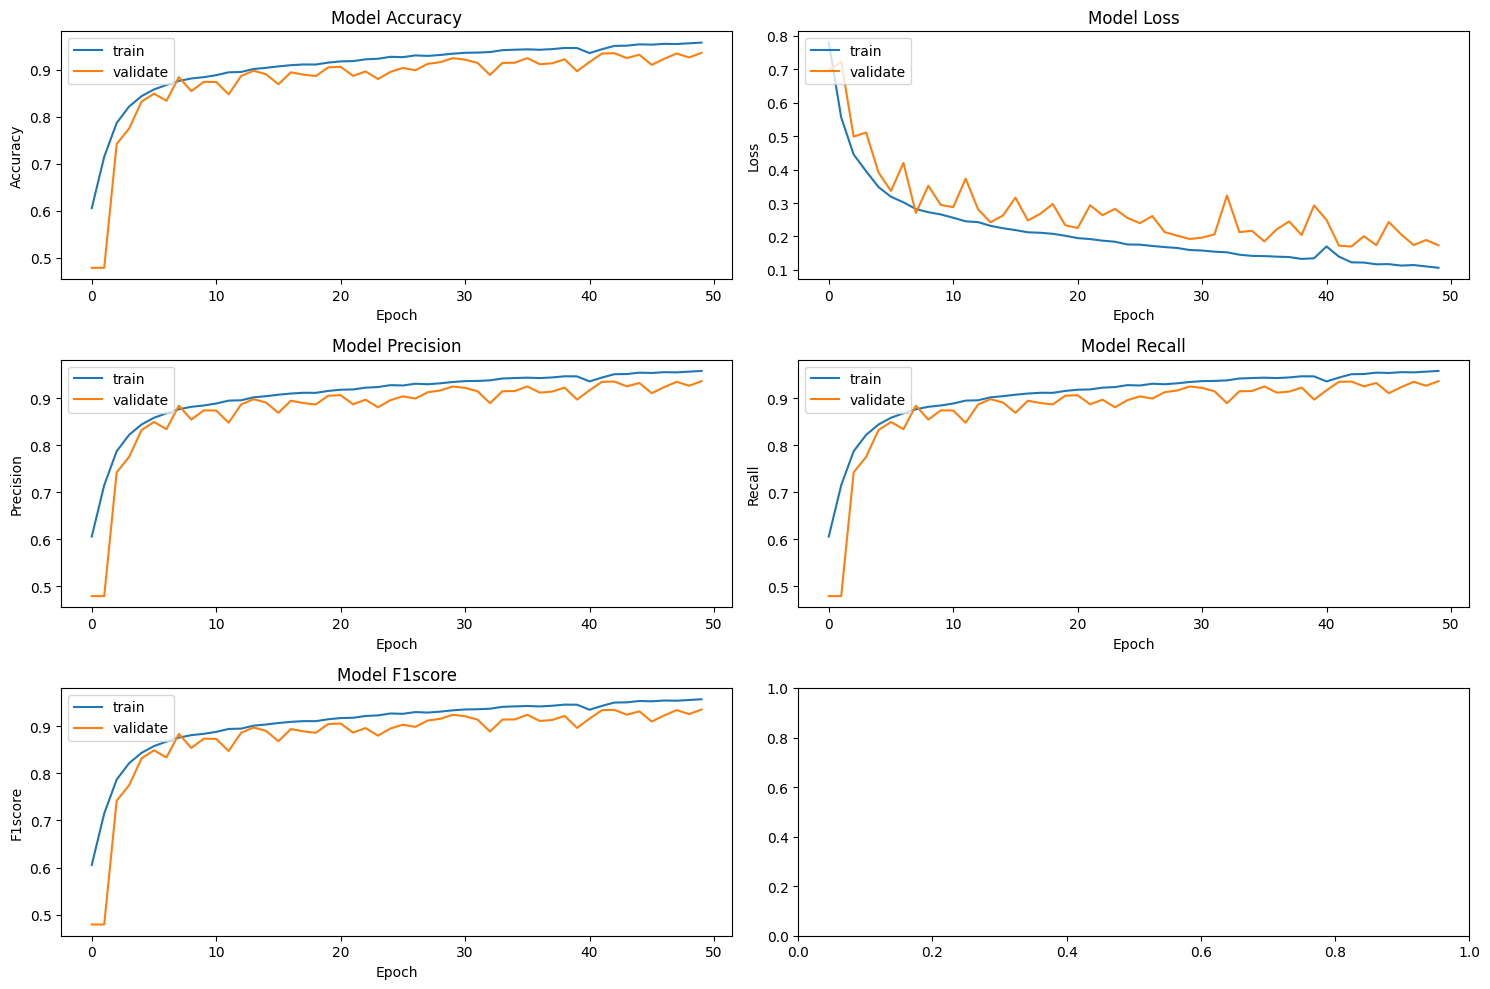

In [14]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Plot accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['train', 'validate'], loc='upper left')

    # Plot loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['train', 'validate'], loc='upper left')

    # Plot precision_m
    axs[1, 0].plot(history.history['precision_m'])
    axs[1, 0].plot(history.history['val_precision_m'])
    axs[1, 0].set_title('Model Precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['train', 'validate'], loc='upper left')

    # Plot recall_m
    axs[1, 1].plot(history.history['recall_m'])
    axs[1, 1].plot(history.history['val_recall_m'])
    axs[1, 1].set_title('Model Recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['train', 'validate'], loc='upper left')

    # Plot f1score_m
    axs[2, 0].plot(history.history['f1_m'])
    axs[2, 0].plot(history.history['val_f1_m'])
    axs[2, 0].set_title('Model F1score')
    axs[2, 0].set_ylabel('F1score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['train', 'validate'], loc='upper left')

    plt.tight_layout()
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [15]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_test, Y_test, verbose=0)
print("Loss of test set is: ",lost_test)
print("Accuracy of test set is: ",accuracy_test)
print("F1score of test set is: ",f1score_test)
print("Precision of test set is: ",precision_test)
print("Recall of test set is: ",recall_test)

Loss of test set is:  0.42303603887557983
Accuracy of test set is:  0.8679569959640503
F1score of test set is:  0.8679569959640503
Precision of test set is:  0.8679569959640503
Recall of test set is:  0.8679569959640503


### Draw confusion matrix

In [18]:
label

array(['right thumb', 'left thumb'], dtype='<U11')

In [20]:
labels = list(label)
labels

['right thumb', 'left thumb']

1911/1911 [==============================] - 15s 8ms/step


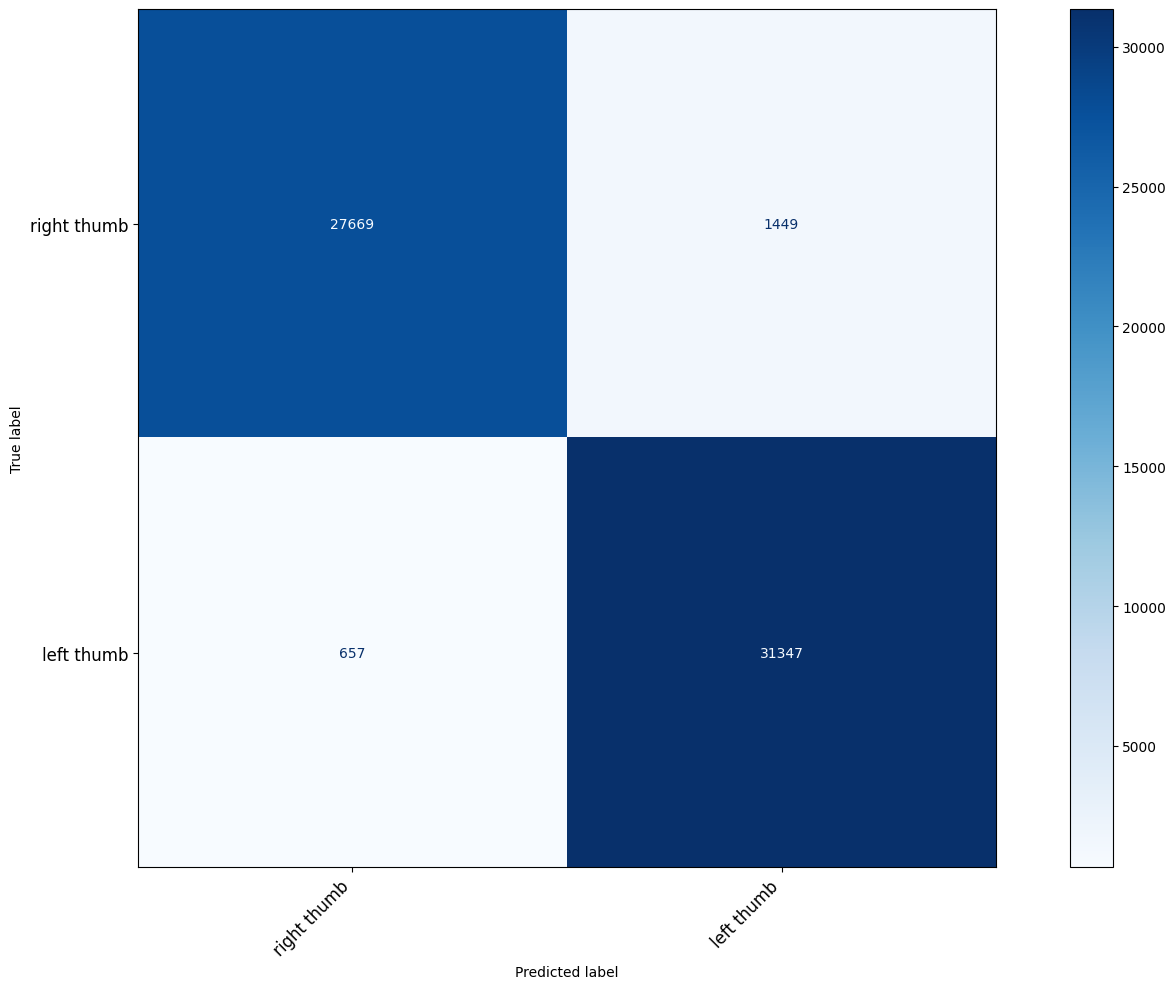

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_train, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


599/599 [==============================] - 4s 7ms/step


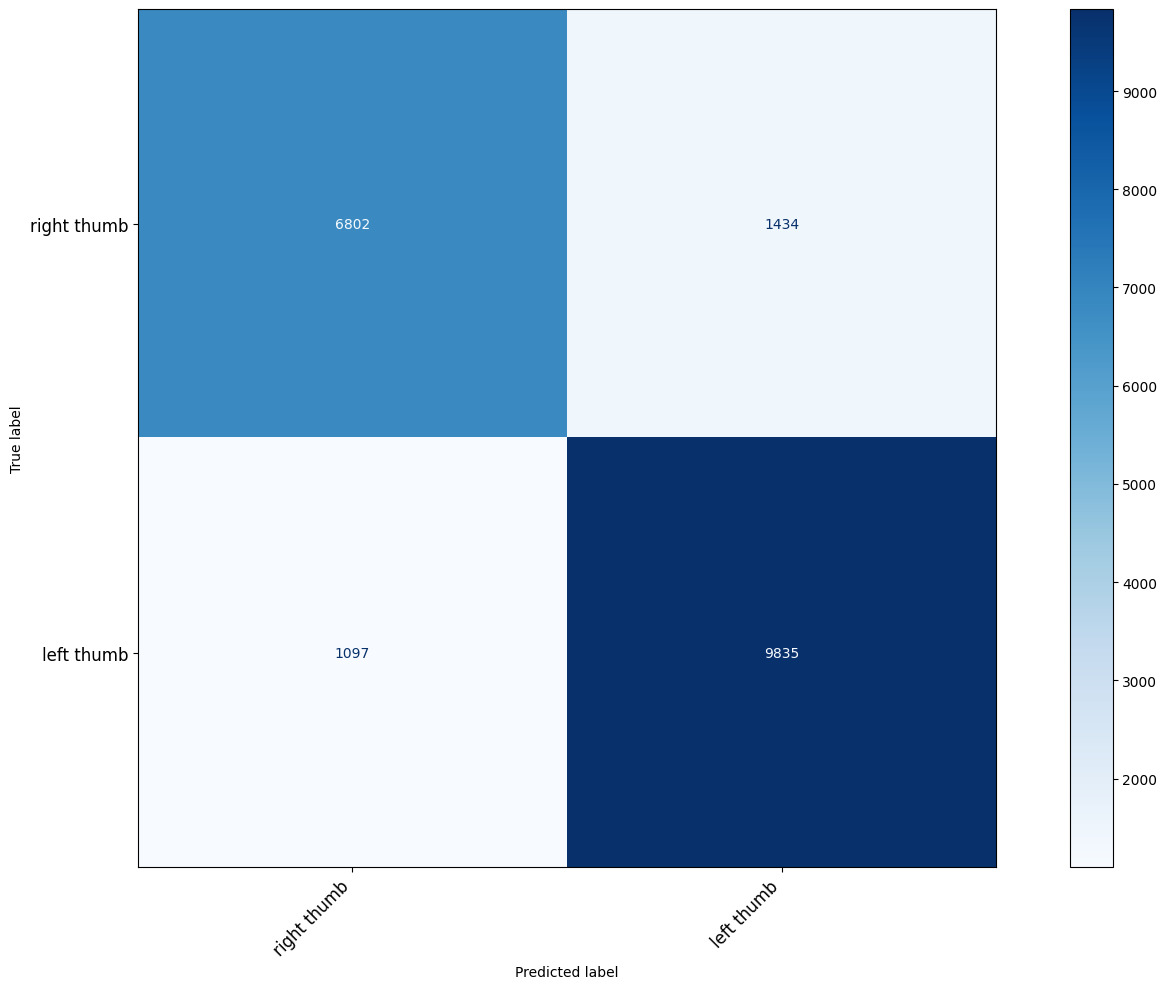

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


In [23]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((61122, 32, 32, 1), (61122, 2), (19168, 32, 32, 1), (19168, 2))